In [2]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_407164/1034334488.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(f, map_location="cpu")
/tmp/ipykernel_407164/1034334488.py:63: FutureW

           method  count     mean      std
Deterministic MLP      5 0.000054 0.000849
        Diffusion     20 0.003301 0.005016
         Gaussian     15 0.019558 0.026949
Diffusion (point)      5 0.041622 0.000798


/tmp/ipykernel_407164/1034334488.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


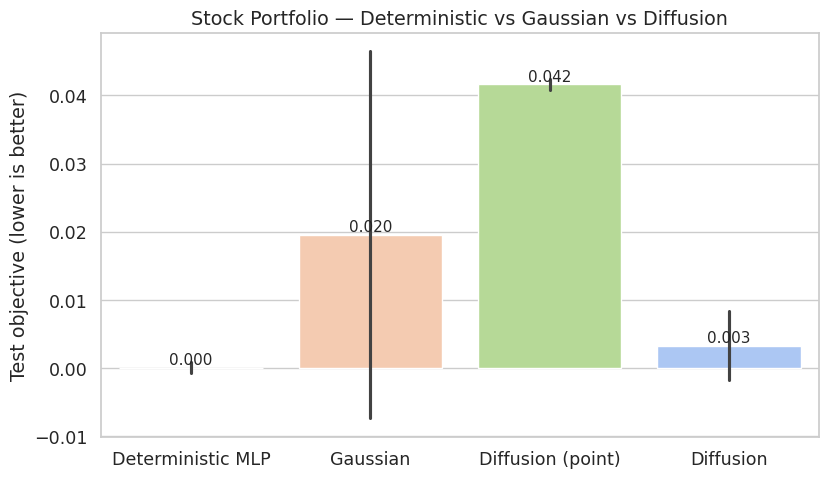

In [3]:
BASE_DIR = Path("stock_portfolio_results_50")
PREFERRED_KEYS = ["test_obj", "objective", "obj", "loss", "metric", "val_obj", "val_loss"]

def extract_score(obj):
    if isinstance(obj, (int, float)):
        return float(obj)
    try:
        import torch
        if isinstance(obj, torch.Tensor) and obj.numel() == 1:
            return float(obj.item())
    except Exception:
        pass

    if isinstance(obj, dict):
        for k in PREFERRED_KEYS:
            if k in obj and isinstance(obj[k], (int, float)):
                return float(obj[k])
            if k in obj and "item" in dir(obj[k]):
                try:
                    return float(obj[k].item())
                except Exception:
                    pass
        for v in obj.values():
            if isinstance(v, (int, float)):
                return float(v)
            if hasattr(v, "item"):
                try:
                    return float(v.item())
                except Exception:
                    pass
    raise ValueError("Cannot parse score from object")

def parse_method_label(stem: str):
    if stem.startswith("diffusion-"):
        if "-distr_est-" in stem:
            return "Diffusion (distr)"
        elif "-point_est-" in stem:
            return "Diffusion (point)"
        else:
            return "Diffusion"
    if "gaussian" in stem:
        return "Gaussian"
    if "deterministic_mlp" in stem:
        return "Deterministic MLP"
    return "Other"

def parse_seed(stem: str):
    m = re.search(r"SEED(\d+)", stem)
    return int(m.group(1)) if m else None

records = []
for sub in sorted(BASE_DIR.glob("*")):
    if not sub.is_dir():
        continue
    for f in sorted(sub.glob("*")):
        if not f.is_file() or f.suffix == ".pth":
            continue
        stem = f.name
        try:
            obj = torch.load(f, map_location="cpu")
        except Exception:
            try:
                obj = torch.load(str(f), map_location="cpu")
            except Exception:
                continue

        try:
            score = extract_score(obj)
        except Exception:
            continue

        method = parse_method_label(stem)
        seed = parse_seed(stem)
        records.append({"method": method, "seed": seed, "score": score, "path": str(f)})

df = pd.DataFrame(records)
if df.empty:
    raise SystemExit("No results found (check BASE_DIR path and files exist and are not .pth).")

keep_methods = ["Deterministic MLP", "Gaussian", "Diffusion (point)", "Diffusion"]
df = df[df["method"].isin(keep_methods)]

summary = (
    df.groupby("method")["score"]
      .agg(["count", "mean", "std"])
      .sort_values("mean")
      .reset_index()
)
print(summary.to_string(index=False))

sns.set_theme(style="whitegrid", font_scale=1.15)
PALETTE = {
    "Deterministic MLP": "#8EC5FF",  
    "Gaussian":          "#FFC9A6",  
    "Diffusion (point)": "#B5E48C",  
    "Diffusion":         "#A0C4FF",  
}

order = [m for m in ["Deterministic MLP","Gaussian","Diffusion (point)","Diffusion"]
         if m in df["method"].unique()]

plt.figure(figsize=(8.5, 5))
ax = sns.barplot(
    data=df,
    x="method", y="score",
    order=order,
    estimator=np.mean,
    errorbar="sd",
    palette=PALETTE
)

group_means = df.groupby("method")["score"].mean()
for i, m in enumerate(order):
    if m in group_means:
        val = group_means[m]
        ax.text(i, val, f"{val:.3f}", ha="center", va="bottom", fontsize=11)

ax.set_xlabel("")
ax.set_ylabel("Test objective (lower is better)")
ax.set_title("Stock Portfolio — Deterministic vs Gaussian vs Diffusion")
plt.tight_layout()
# plt.savefig("stock_portfolio_method_compare.png", dpi=200)
plt.show()

# df.sort_values(["method","seed"]).to_csv("stock_portfolio_method_details.csv", index=False)
# print("Saved: stock_portfolio_method_compare.png, stock_portfolio_method_details.csv")


In [4]:
optimal = {'10':3.086104, '25': 4.325979, '50': 5.433849, '75': 6.176259, '100': 6.806670}

/tmp/ipykernel_407164/3279026235.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(f, map_location="cpu")
/tmp/ipykernel_407164/3279026235.py:81: FutureW

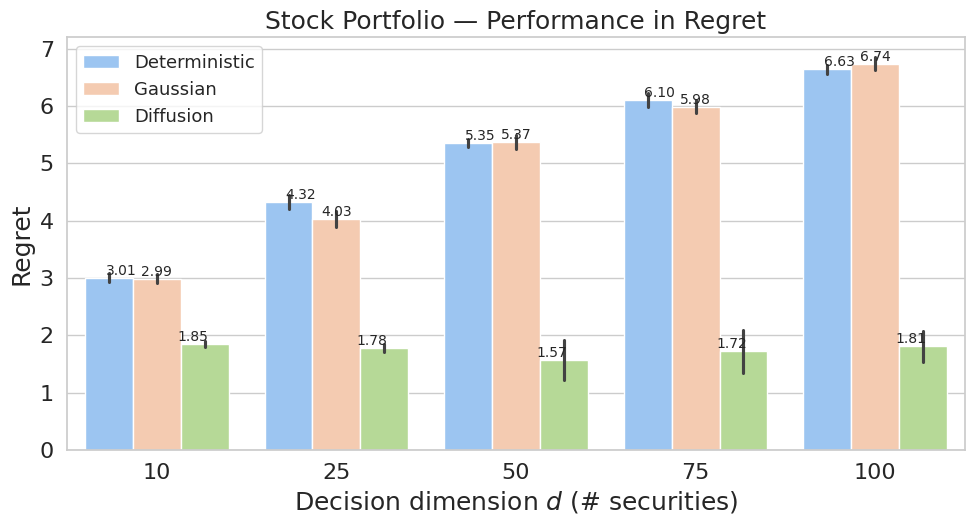

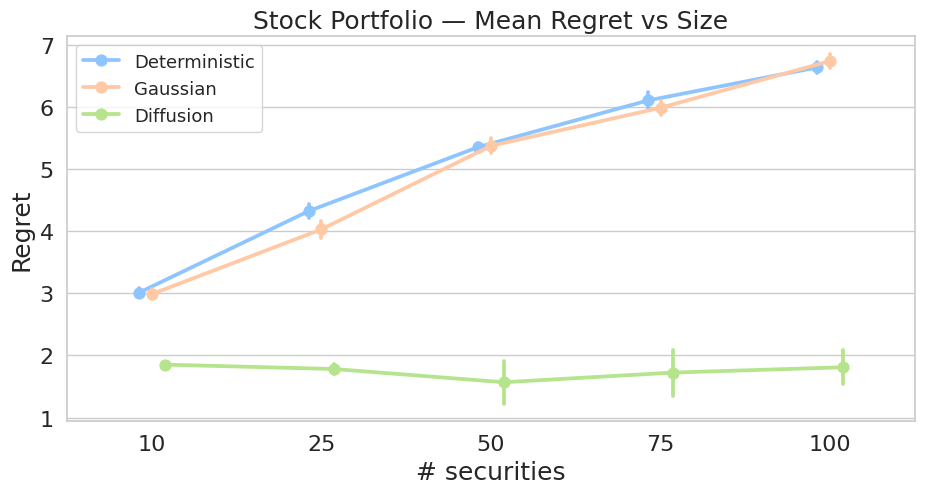

In [1]:
import os, re, json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

SIZES = [10, 25, 50, 75, 100]
DIR_TPL = "stock_portfolio_results_{n}"
PREFERRED_KEYS = ["test_obj", "objective", "obj", "loss", "metric", "val_obj", "val_loss"]
OPTIMAL = {'10':3.086104, '25':4.325979, '50':5.433849, '75':6.176259, '100':6.806670}

KEEP_METHODS = ["Deterministic", "Gaussian", "Diffusion"]
PALETTE = {
    "Deterministic": "#8EC5FF",
    "Gaussian":          "#FFC9A6",
    "Diffusion": "#B5E48C",
    # "Diffusion":         "#A0C4FF",
}

def extract_score(obj):
    if isinstance(obj, (int, float)):
        return float(obj)
    try:
        if isinstance(obj, torch.Tensor) and obj.numel() == 1:
            return float(obj.item())
    except Exception:
        pass
    if isinstance(obj, dict):
        for k in PREFERRED_KEYS:
            if k in obj and isinstance(obj[k], (int, float)):
                return float(obj[k])
            if k in obj and hasattr(obj[k], "item"):
                try:
                    return float(obj[k].item())
                except Exception:
                    pass
        for v in obj.values():
            if isinstance(v, (int, float)):
                return float(v)
            if hasattr(v, "item"):
                try:
                    return float(v.item())
                except Exception:
                    pass
    raise ValueError("Cannot parse score from object")

def parse_method_label(stem: str):
    if stem.startswith("diffusion-"):
        return "Diffusion"
    if "gaussian" in stem:
        return "Gaussian"
    if "deterministic_mlp" in stem:
        return "Deterministic"
    return "Other"

def parse_seed(stem: str):
    m = re.search(r"SEED(\d+)", stem)
    return int(m.group(1)) if m else None

all_records = []
for n in SIZES:
    base = Path(DIR_TPL.format(n=n))
    if n == 50:
        base = Path("stock_portfolio_results_50_2")
    if not base.exists():
        print(f"[warn] missing dir: {base}")
        continue
    for sub in sorted(base.glob("*")):
        if not sub.is_dir():
            continue
        for f in sorted(sub.glob("*")):
            if not f.is_file() or f.suffix == ".pth":
                continue
            stem = f.name
            try:
                obj = torch.load(f, map_location="cpu")
            except Exception:
                try:
                    obj = torch.load(str(f), map_location="cpu")
                except Exception:
                    continue
            try:
                score = extract_score(obj)
            except Exception:
                continue
            method = parse_method_label(stem)
            seed = parse_seed(stem)
            all_records.append({
                "n": n,
                "method": method,
                "seed": seed,
                "score": float(score),
                "path": str(f)
            })

df = pd.DataFrame(all_records)
if df.empty:
    raise SystemExit("No results found across sizes.")

df = df[df["method"].isin(KEEP_METHODS)].copy()

# compute regret = optimal[n] - score
df["n_str"] = df["n"].astype(str)
df["optimal"] = df["n_str"].map(OPTIMAL)

scale_methods = ["Deterministic", "Gaussian", "Diffusion"]
df.loc[df["method"].isin(scale_methods), "score"] *= 100

df["regret"] = df["optimal"] - df["score"]

df = df.drop(columns=["n_str"])
df = df.sort_values(["n","method","seed"])
# df.to_csv("stock_portfolio_all_runs_with_regret.csv", index=False)

summary = (df.groupby(["n","method"])["regret"]
             .agg(count="count", mean="mean", std="std")
             .reset_index()
             .sort_values(["n","mean"]))
# summary.to_csv("stock_portfolio_regret_summary.csv", index=False)
# print(summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# sns.set_theme(style="whitegrid", font_scale=1.15)
sns.set_theme(style="whitegrid", font_scale=1.25, rc={
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 13,
    "legend.title_fontsize": 13,
})

order_methods = [m for m in KEEP_METHODS if m in df["method"].unique()]
plt.figure(figsize=(10, 5.5))
ax = sns.barplot(
    data=df, x="n", y="regret", hue="method",
    order=sorted(df["n"].unique()),
    hue_order=order_methods, estimator=np.mean, errorbar="sd",
    palette=PALETTE
)
# annotate means
group_means = df.groupby(["n","method"])["regret"].mean()
for i, n in enumerate(sorted(df["n"].unique())):
    for j, m in enumerate(order_methods):
        if (n, m) in group_means.index:
            val = group_means.loc[(n,m)]
            ax.text(i + (j - (len(order_methods)-1)/2)*0.2,  # offset near bar center
                    val, f"{val:.2f}", ha="center", va="bottom", fontsize=10, rotation=0)

ax.set_xlabel(r"Decision dimension $d$ (# securities)")
ax.set_ylabel("Regret")
ax.set_title("Stock Portfolio — Performance in Regret")
ax.legend(title="")
plt.tight_layout()
plt.savefig("stock_portfolio_regret.pdf", dpi=300)

plt.figure(figsize=(9.5, 5.2))
ax2 = sns.pointplot(
    data=df, x="n", y="regret", hue="method",
    order=sorted(df["n"].unique()),
    hue_order=order_methods, errorbar="sd", dodge=0.15, markers="o",
    palette=PALETTE
)
ax2.set_xlabel("# securities")
ax2.set_ylabel("Regret")
ax2.set_title("Stock Portfolio — Mean Regret vs Size")
ax2.legend(title="")
plt.tight_layout()
# plt.savefig("stock_portfolio_regret_lines.png", dpi=220)
plt.show()
